In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.cosmic_shear_map.cosmic_shear import *
import ndes.ndes as ndes
import delfi.delfi as delfi
import distributions.priors as priors
import time
import compression.score.score as score
import tensorflow as tf
import IMNN.IMNN as IMNN
import IMNN.ABC.ABC as ABC
%matplotlib inline

In [ ]:
# Set up...

# Redshift distributions
pz_fid = pickle.load(open('simulators/cosmic_shear_map/pz_5bin.pkl', 'rb'))
nz = len(pz_fid)

# Fiducial parameters about which data compression is performed
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

# Set up the truncated Gaussian prior...

# Prior boundaries
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])

# Prior mean and covariance
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
prior_covariance = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2

# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

# Parameter names and ranges for plotting...  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Simulation set-up...

# Resolution
nside = 128
lmax = 3*nside-1
lmin = 10
n_ell_bins = 7
npix = hp.nside2npix(nside)

# Mask (Euclid)
mask = hp.read_map('simulators/cosmic_shear_map/Euclid_footprint_and_StarMask512.fits')
if nside != 512:
    mask = hp.pixelfunc.ud_grade(mask, nside)
mask = np.array([mask for x in range(nz)])

# Pixel-space shape noise standard deviation at each redshift
sigma_e = 0.3
n_p_mean = 1.6e9/sum(mask)
sig_n_p = sigma_e**2/np.random.poisson(n_p_mean, size=(nz, npix))

# Simulation and simulation arguments
def simulator(theta, seed, simulator_args, batch):
    return simulate(theta, seed, simulator_args, batch)[0,:]
simulator_args = [pz_fid, lmin, lmax, sig_n_p, mask, n_ell_bins]

# Simulate data (and time it for benchmarking)
start = time.time()
data = simulator(theta_fiducial, 0, simulator_args, 1)
print(time.time()-start)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
8.120063781738281


In [ ]:
# Define the input shape
input_shape = [n_ell_bins*nz*(nz+1)//2]

In [ ]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
θ_fid = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
Δθpm = θ_fid*0.05

# Compute the mean and covariance
n_sims_for_covariance = 6000 # 3000 for training and another 3000 for validation
Compressor = score.Gaussian(len(data), theta_fiducial, prior_mean = prior_mean, prior_covariance = prior_covariance)
Compressor.compute_mean_covariance(simulator, n_sims_for_covariance, simulator_args = simulator_args)
sims = Compressor.simulations

# Fiducial sims (and validation ones)
IMNN_data = {"data": sims[0:3000,:], "validation_data": sims[3000:,:]}

# Compute the derivatives
n_sims_for_derivatives = 100
Compressor.compute_derivatives(simulator, n_sims_for_derivatives, Δθpm, simulator_args = simulator_args)

# Derivative sims (incl for validation case: use same for both should be stable)
IMNN_data["data_d"] = np.array([Compressor.dmudt])
IMNN_data["validation_data_d"] = np.array([Compressor.dmudt])

In [80]:
parameters = {
    "dtype": 32,
    "number of simulations": 3000,
    "number of derivative simulations": 1,
    "fiducial": θ_fid.tolist(),
    "number of summaries": 5,
    "input shape": input_shape,
    "filename": "simulators/cosmic_shear_map/data/model",
}

tf.reset_default_graph()
n = IMNN.IMNN(parameters = parameters)

def build_network(data, **kwargs):
    α = kwargs["activation_parameter"]
    with tf.variable_scope("layer_1"):
        weights = tf.get_variable("weights", shape = [input_shape[-1] + 1, 128], initializer = tf.variance_scaling_initializer())
        output = tf.nn.leaky_relu(tf.matmul(tf.concat([data, tf.ones((tf.shape(data)[0], 1))], axis = 1), weights, name = "multiply"), α, name = "output")
    with tf.variable_scope("layer_2"):
        weights = tf.get_variable("weights", shape = [128 + 1, 128], initializer = tf.variance_scaling_initializer())
        output = tf.nn.leaky_relu(tf.matmul(tf.concat([output, tf.ones((tf.shape(output)[0], 1))], axis = 1), weights, name = "multiply"), α, name = "output")
    with tf.variable_scope("layer_3"):
        weights = tf.get_variable("weights", shape = (128 + 1, n.n_summaries), initializer = tf.variance_scaling_initializer())
        output = tf.identity(tf.matmul(tf.concat([output, tf.ones((tf.shape(output)[0], 1))], axis = 1), weights, name = "multiply"), name = "output")
    return output

α = tf.placeholder(dtype = tf.float32, shape = (), name = "activation_parameter")
network = lambda x: build_network(x, activation_parameter = α, input_shape = input_shape)
graph_dictionary = {"activation_parameter:0": 0.001}

n.setup(network = network, load_data = IMNN_data)

saving the graph as simulators/cosmic_shear_map/data/model.meta


In [81]:
# Train the IMNN
updates = 10000
at_once = 1000
learning_rate = 1e-4

n.train(updates, at_once, learning_rate, constraint_strength = 2.,
        training_dictionary = graph_dictionary,
        validation_dictionary = graph_dictionary,
        get_history = True, restart = False, diagnostics = False)

InvalidArgumentError: Input is not invertible.
	 [[node inverse_covariance (defined at /usr/local/lib/python3.6/site-packages/IMNN/IMNN.py:721)  = MatrixInverse[T=DT_FLOAT, adjoint=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](covariance)]]

Caused by op 'inverse_covariance', defined at:
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-80-6a87190073a3>", line 31, in <module>
    n.setup(network = network, load_data = IMNN_data)
  File "/usr/local/lib/python3.6/site-packages/IMNN/IMNN.py", line 721, in setup
    inv_cov = tf.linalg.inv(cov, name="inverse_covariance")
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 1041, in matrix_inverse
    "MatrixInverse", input=input, adjoint=adjoint, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Input is not invertible.
	 [[node inverse_covariance (defined at /usr/local/lib/python3.6/site-packages/IMNN/IMNN.py:721)  = MatrixInverse[T=DT_FLOAT, adjoint=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](covariance)]]


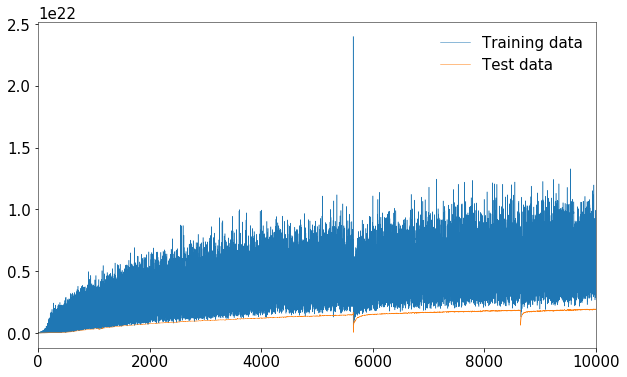

In [57]:
# Plot the IMNN training curve
fig, ax = plt.subplots(1, 1, sharex = True, figsize = (10, 6))
epochs = np.arange(1, len(n.history["det F"]) + 1)
ax.plot(epochs, n.history["det F"], label = 'Training data')
ax.plot(epochs, n.history["det test F"], label = 'Test data')
ax.legend(frameon = False)
ax.set_xlim([1, epochs[-1]]);

In [58]:
# Compress to IMNN summaries
def compressor(data, compressor_args):
    return n.sess.run("MLE:0", feed_dict = {**graph_dictionary, **{"data:0": np.atleast_2d(data)}})[0,:]
compressor_args = None


# Compressed data
real_data = simulator(θ_fid, 0, simulator_args, 1)
compressed_data = compressor(real_data, compressor_args)

# Inverse Fisher matrix from IMNN
abc = ABC.ABC(real_data = np.array([real_data]), prior = prior, sess = n.sess, get_compressor = n.get_compressor, simulator = simulator, seed = None, simulator_args = {"input shape": input_shape}, dictionary = graph_dictionary)
F = abc.fisher
Finv = np.linalg.inv(F)

In [59]:
# Create an ensemble of NDEs (here, Mixture Density Networks)
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=5, n_data=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]

# Create the DELFI object
DelfiMDN = delfi.Delfi(compressed_data, prior, NDEs, Finv=Finv, theta_fiducial=θ_fid, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear_map/results/imnn_mdn",
                       input_normalization='fisher')

In [60]:
# Do the Fisher pre-training
DelfiMDN.fisher_pretraining()

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


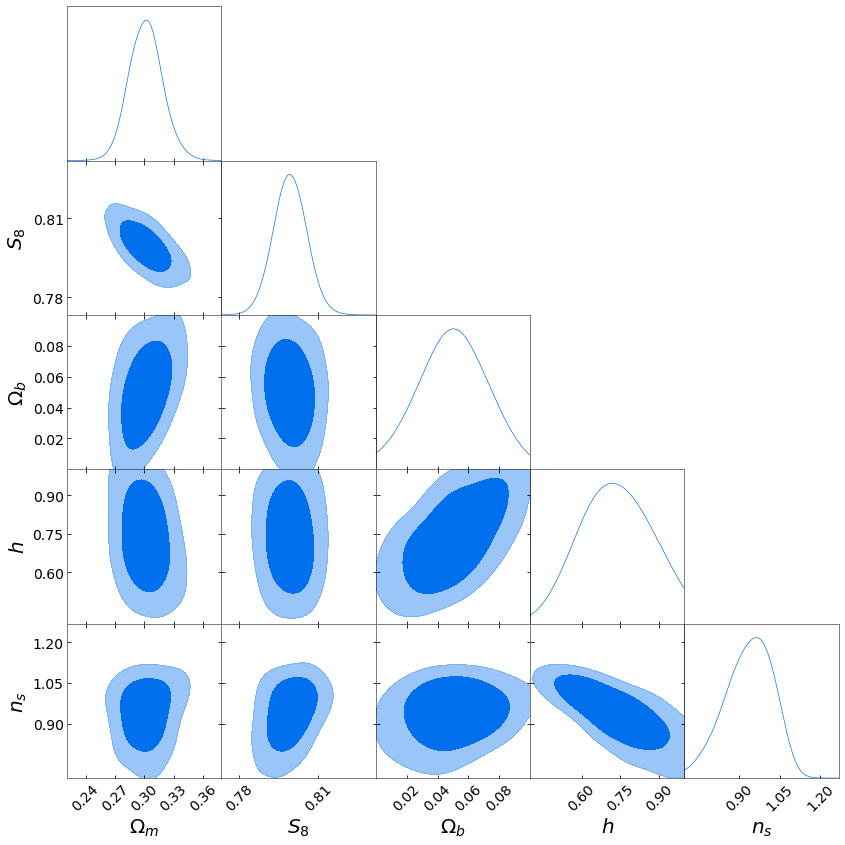

Population 1/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


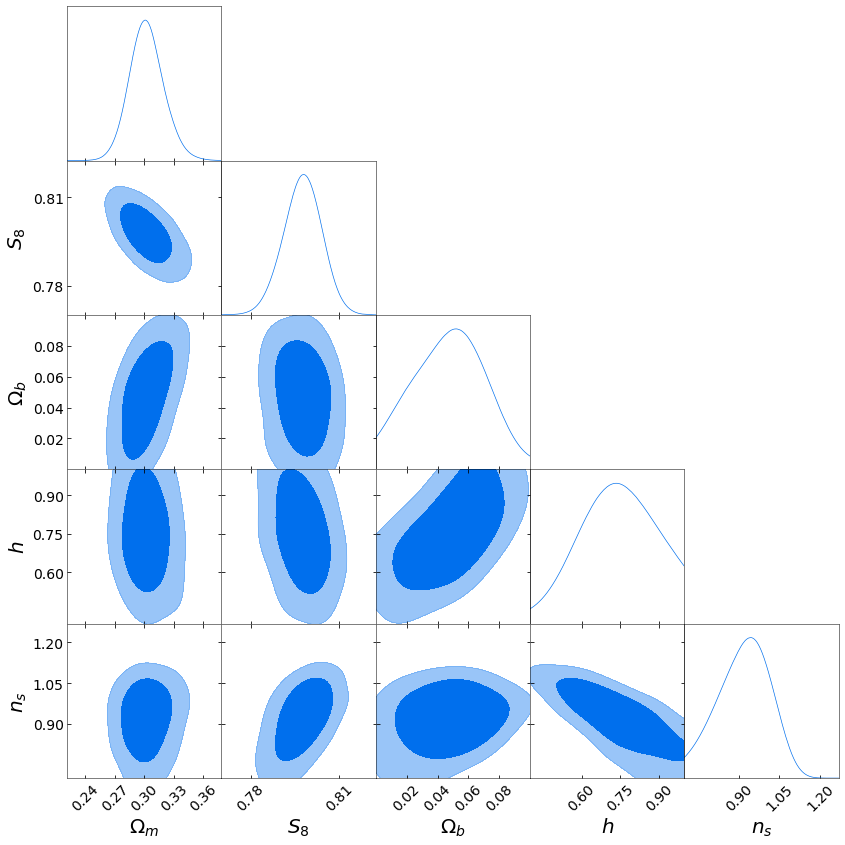

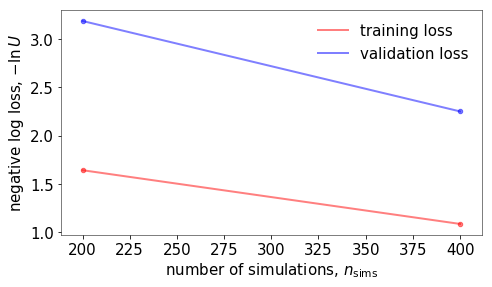

Population 2/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


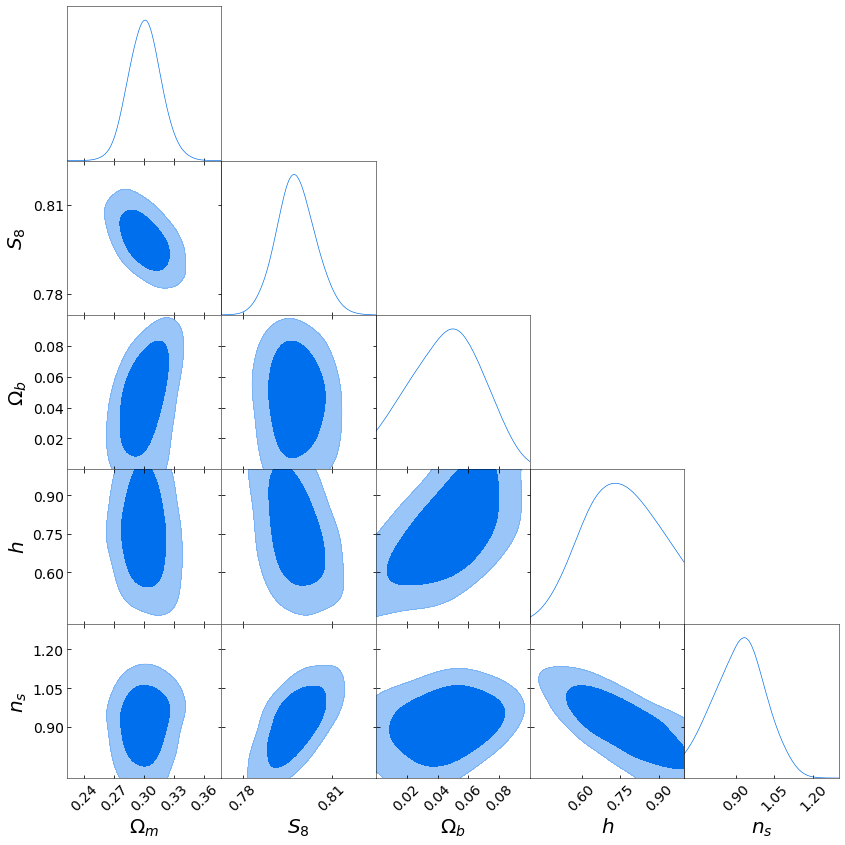

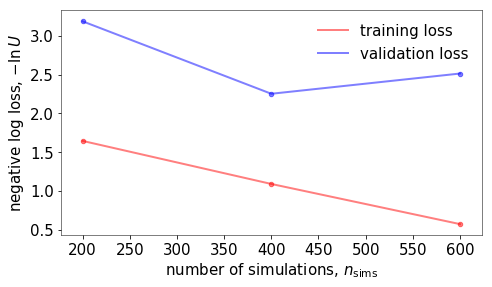

Population 3/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


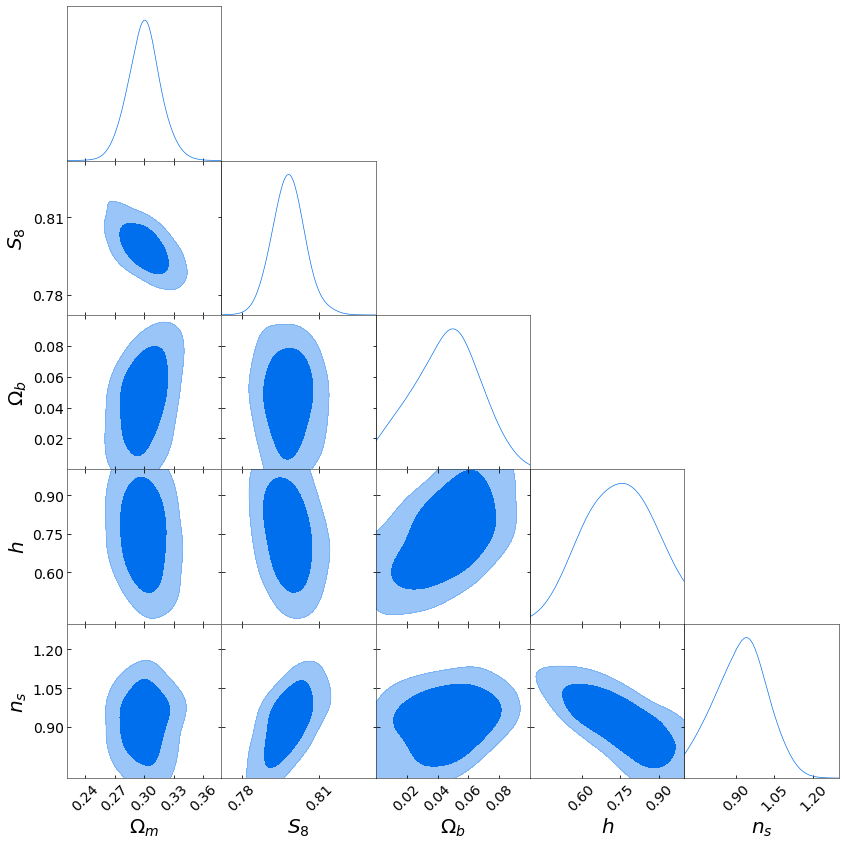

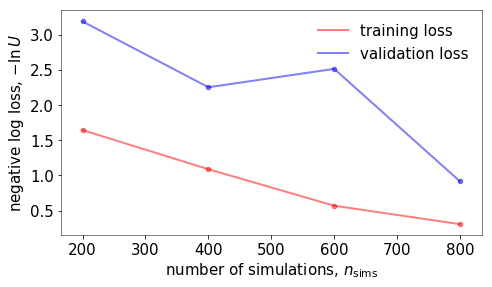

Population 4/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


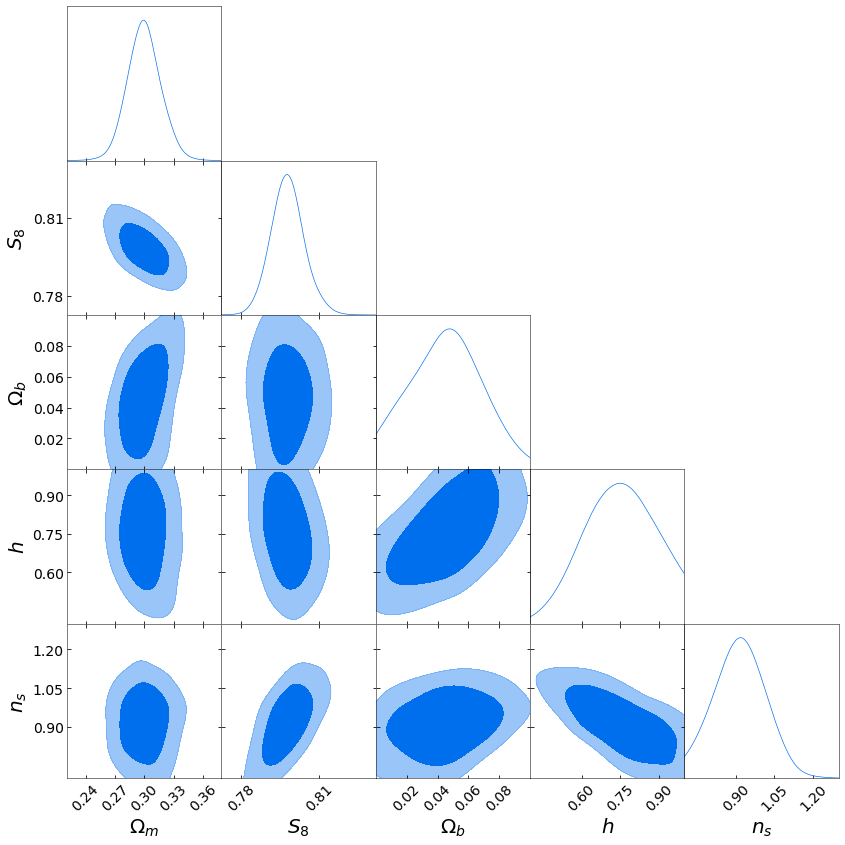

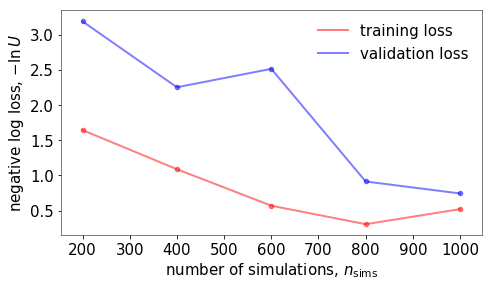

Population 5/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


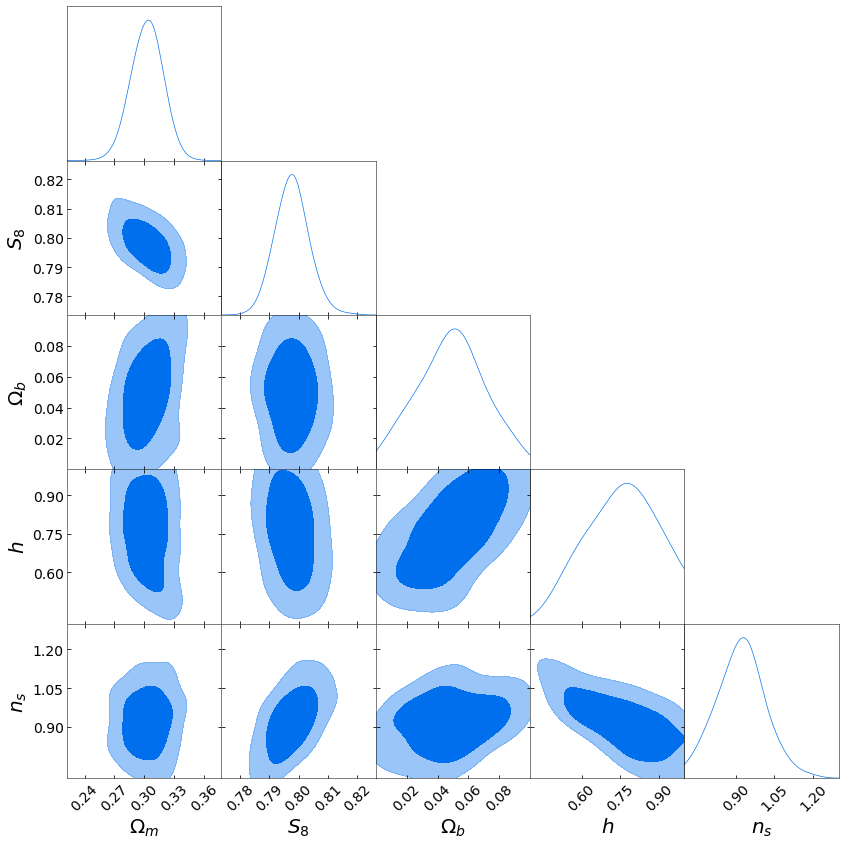

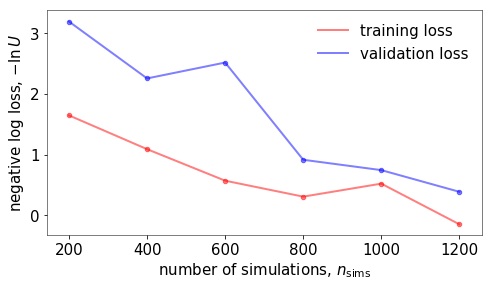

Population 6/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


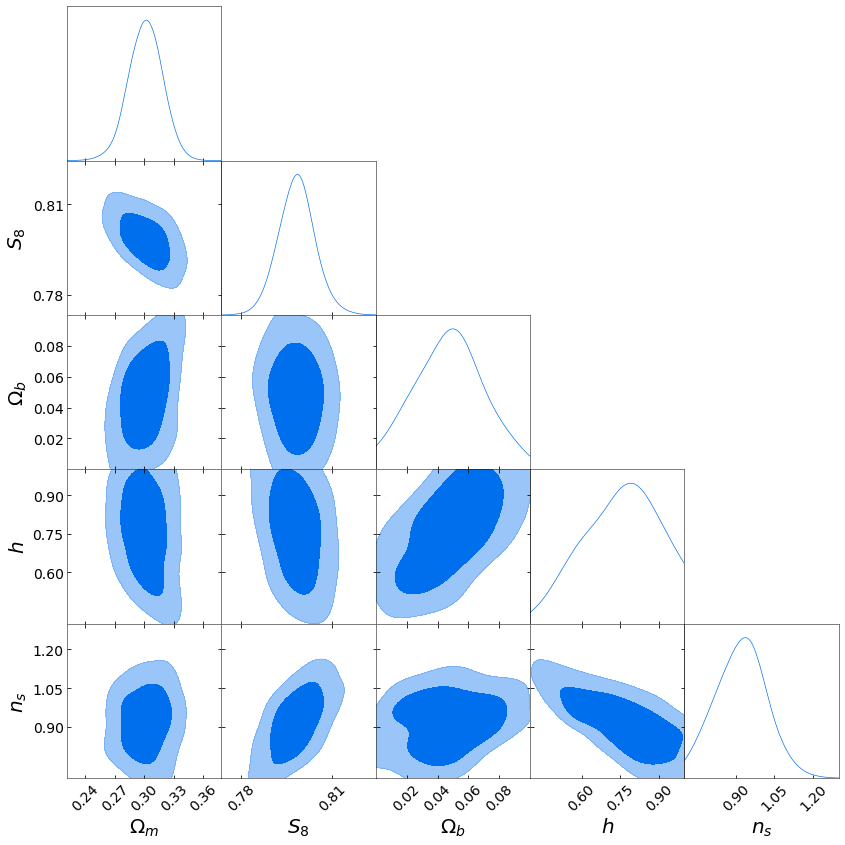

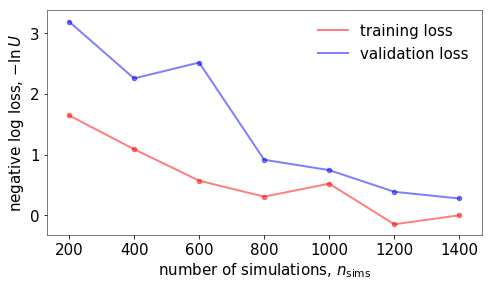

Population 7/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


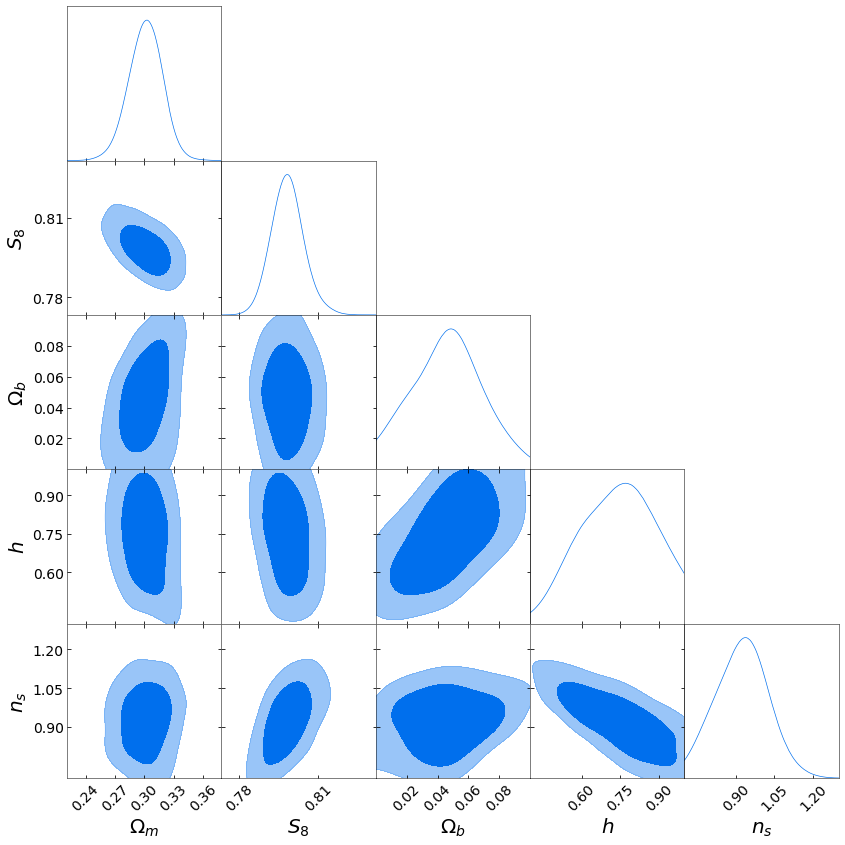

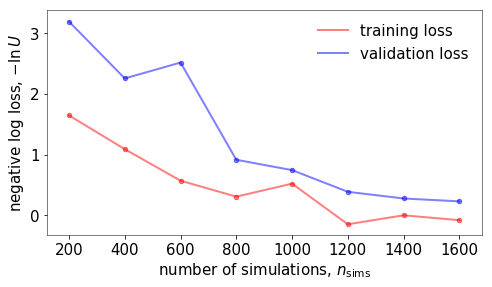

Population 8/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


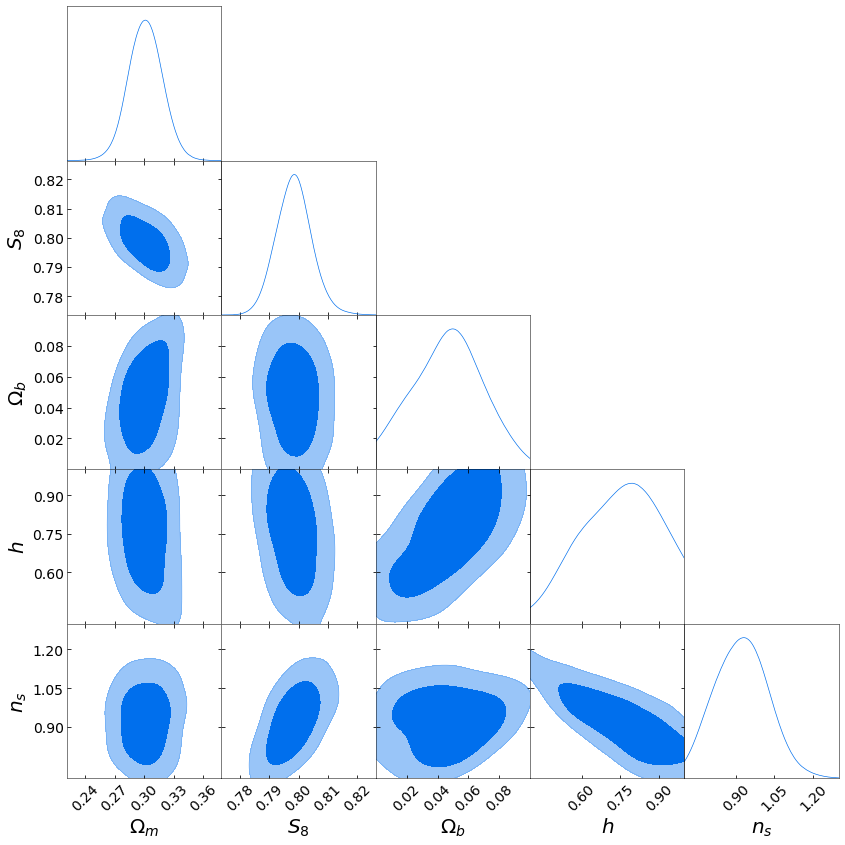

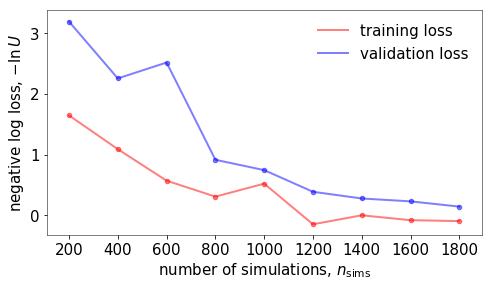

Population 9/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


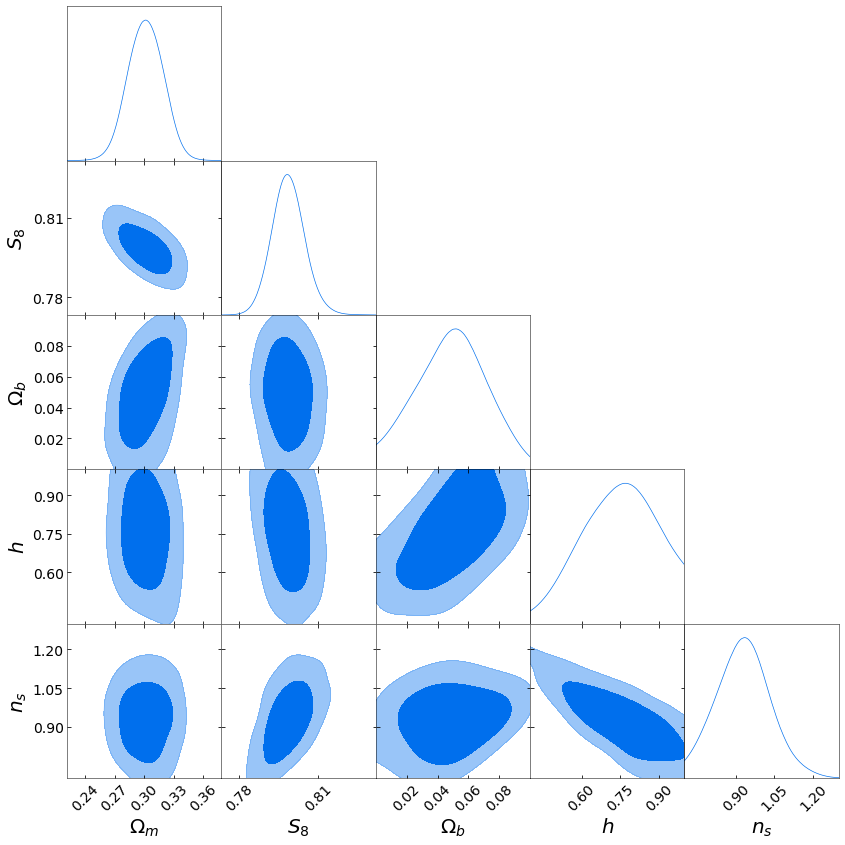

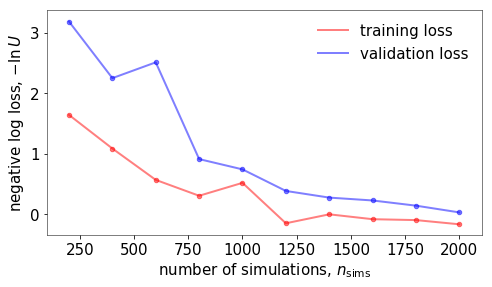

Population 10/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


Sampling approximate posterior...
Done.
Removed no burn in


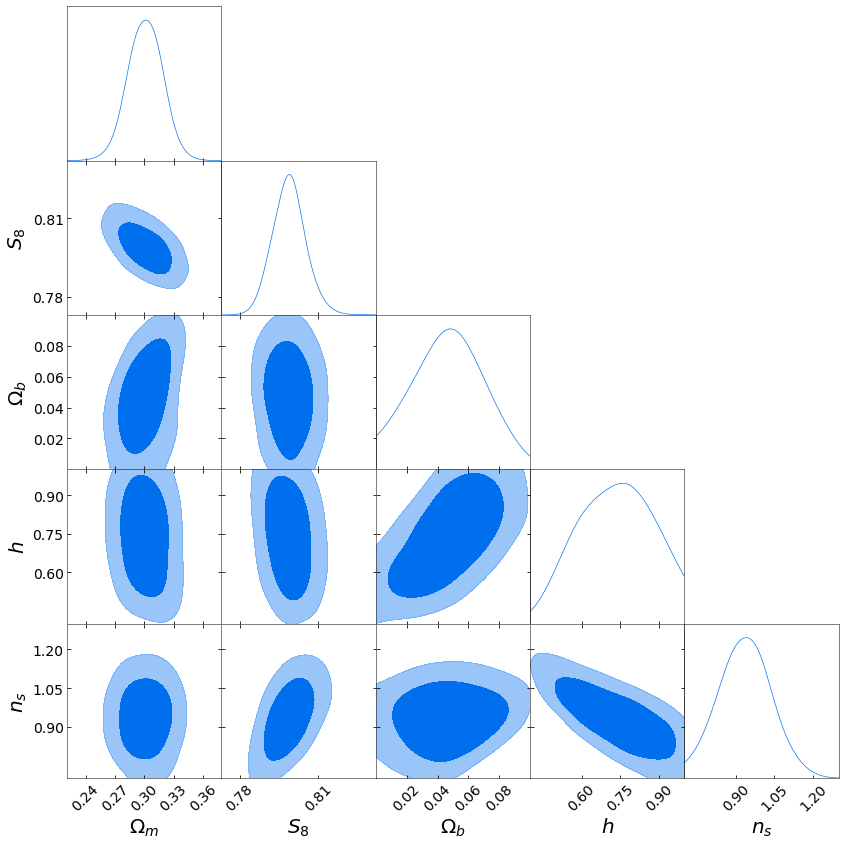

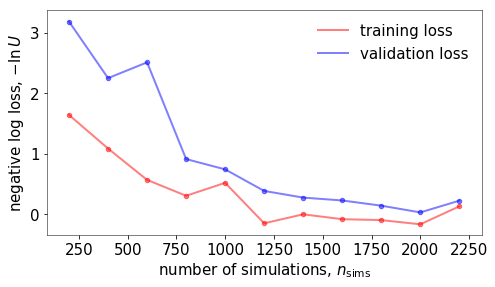

Population 11/39
Sampling proposal density...
Done.


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear_map/results/imnn_mdntmp_model


Sampling approximate posterior...
emcee: Exception while calling your likelihood function:
  params: [0.32166651 0.79278088 0.07875122 0.86646017 0.89100505]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/justinalsing/Dropbox/science/delfi/master/delfi/delfi/delfi.py", line 196, in log_posterior_stacked
    return self.log_likelihood_stacked(x) + self.prior.logpdf(x)
  File "/Users/justinalsing/Dropbox/science/delfi/master/delfi/delfi/delfi.py", line 183, in log_likelihood_stacked
    L += self.stacking_weights[n]*np.exp(self.nde[n].eval((np.atleast_2d((theta-self.p_mean)/self.p_std), np.atleast_2d((self.data-self.x_mean)/self.x_std)), self.sess))
  File "/Users/justinalsing/Dropbox/science/delfi/master/delfi/ndes/ndes.py", line 197, in eval
    lprob = sess.run(self.L,feed_dict={self.parameters:x,self.data:y})
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 929, in run
    run_metadata_ptr)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/client

KeyboardInterrupt: 

In [61]:
# Initial samples, batch size for population samples, number of populations
n_initial = 200
n_batch = 200
n_populations = 39

# Do the SNL training
DelfiMDN.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, save_intermediate_posteriors=True, simulator_args=simulator_args)

In [40]:
Compressor.compute_fisher()
np.sqrt(np.diag(Compressor.Finv))

array([0.01115837, 0.00431866, 0.01880914, 0.13928424, 0.06575136])

In [39]:
np.sqrt(np.diag(Finv))

array([0.00590913, 0.01055053, 0.00370391, 0.01999387, 0.01818395],
      dtype=float32)

In [43]:
np.linalg.det(Finv)

3.453358e-21

In [44]:
np.linalg.det(Compressor.Finv)

3.1572144029313206e-19